## Variational Quantum Eigensolver - Kris McBrian

Find and compare the ground state energy of a 2x2 matrix using
a quantum circuit and analytical methods

In [257]:
import qiskit as qk
from qiskit.visualization import plot_histogram
import numpy  as np
import matplotlib.pyplot as plt

num_values = 50 # number of angles to evaluate expectation value
backend = qk.Aer.get_backend('qasm_simulator')
n_shots = 2**15 # number of measurments per angle

# Coefficients of Hamiltonian
a = 1.0  # | a   b |
b = 1.0  # | b  -a |

### Define Hamiltonian and experimental expectation values

In [258]:
def H(Z,X,a,b):
    return a*Z + b*X

# called at the end of circuit function
def exp_value(eig, results, n_shots):
    avg = 0.
    # for every result that was measured
    for a in results.keys():
        # obtain index by converting binary measurement to integer
        b = int(a,2)    # e.g. '10' eigenvalue stored at index 2 of eig
        # weighted sum of eigenvalues and number of measurments
        avg += eig[b]*results[a]
    return avg / n_shots

### Functions for theoretical expectation values and Ground State energy

In [259]:
# Ground state energy
def gs_eigenvalue(a,b):
    return -np.sqrt(a**2 + b**2)

# Expectation value of Z
def Z_analytic(theta):
    return np.sin(theta/2)**2 - np.cos(theta/2)**2

# Expectation value of X
def X_analytic(theta):
    return -2.*np.sin(theta/2)*np.cos(theta/2)

### Circuit to take experimental measurements for expectation values
Rotate |0> state about the y-axis by the angle theta, then take measurements in X and in Z

In [260]:
def circuit(theta, n_shots):
    qc = qk.QuantumCircuit(2,2)

    # Rotation applied to each qubit
    qc.ry(theta,0)
    qc.ry(theta,1)

    # Rotation for x-measurement
    qc.h(1)

    qc.measure(0,0)
    qc.measure(1,1)

    exp_values = qk.execute(qc, backend, shots=n_shots)
    results = exp_values.result().get_counts()
    
    # array constructed of eigenvalue corresponding the binary representation of index
        #   [0,1,2,3] --> [00,01,10,11] --> (0's to -1's)
    x = exp_value([-1,-1,1,1],results,n_shots) # leading bit
    z = exp_value([-1,1,-1,1],results,n_shots) # trailing bit
    
    return np.array([z,x])

In [261]:
theta = np.linspace(0,np.pi,num_values)

x_experiment = np.zeros(num_values)
z_experiment = np.zeros(num_values)
x_theory = np.zeros(num_values)
z_theory = np.zeros(num_values)

H_experiment = np.zeros(num_values)
H_theory = np.zeros(num_values)

### Loop circuit over a range of angles
theta: angle at which to rotate |0 > about the y axis before measurement

In [262]:
for i in range(num_values):
    # Get expectation values for X and Z
    z_experiment[i],x_experiment[i] = circuit(theta[i],n_shots)
    # Evaluatate Expectation value of H with < X > and < Z >
    H_experiment[i] = H(z_experiment[i], x_experiment[i], a, b)
    
    # Evaluate < X >, < Z >, and < H > analytically
    x_theory[i] = X_analytic(theta[i])
    z_theory[i] = Z_analytic(theta[i])
    H_theory[i] = H(z_theory[i], x_theory[i], a, b)
                                   

### Results

Theoretical Ground State Energy  = -1.41421 
Experimental Ground State Energy = -1.42639 at 0.769 radians


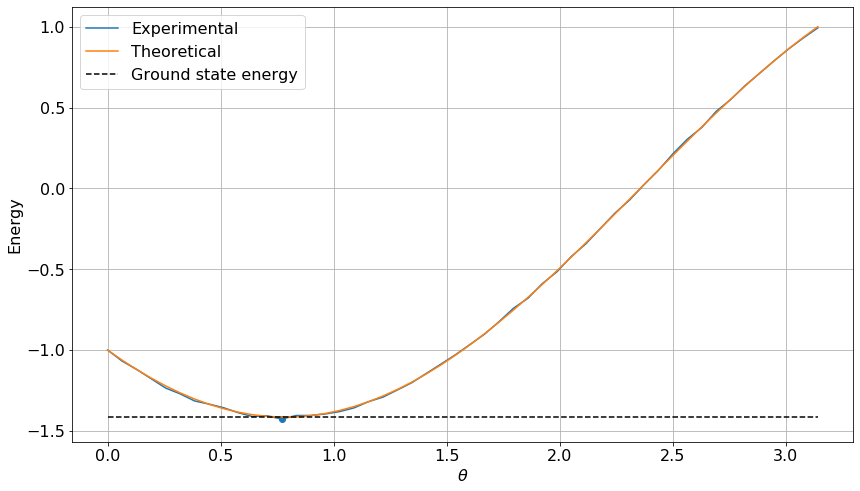

In [268]:
ground_state_energy = gs_eigenvalue(a,b)
print('Theoretical Ground State Energy  = %.5f '%ground_state_energy)
print('Experimental Ground State Energy = %.5f at %.3f radians'%(np.min(H_experiment),theta[np.argmin(H_experiment)]))

min_index = np.argmin(H_experiment)

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(14,8))
plt.plot(theta,H_experiment,label='Experimental')
plt.scatter(theta[min_index],H_experiment[min_index])
plt.plot(theta,H_theory,label='Theoretical')
plt.plot(theta,np.ones(num_values)*ground_state_energy, 'k--',label='Ground state energy')
plt.legend()
plt.grid()
plt.xlabel(r'$\theta$')
plt.ylabel('Energy')
plt.show()